In [5]:
    # Import du script gmc_project\n",
    # Attention, il faut que ton jupyter notebook (le fichier que t'es en train de lire) soit situé dans le répertoire src de GeoMultiCorr (Je ne sais plus où tu l'as installé sur ton pc)\n",
import gmc_project

    # Création d'un objet de la classe GMC_Project, elle même écrite dans le script gmc_project qu'on a importé juste avant
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')

    # Au niveau du projet, on peut récupérer différents trucs
paires_interessantes = etude.get_pairs([2018,2014,'mont-vallon'])
#thumbs_interessantes = etude.get_thumbs([2019, 'aerial'])
paires_interessantes
    # Si on récupére une paire en particulier
#paire_interet = paires_interessantes[0]


    # On peut récupérer d'autres choses à ce niveau
#disparity = paire_interet.get_dispf_geoim()

#disparity_resized = disparity.resize(10, method = 'average')

[---------
 type   : GMC_Pair
 pzone  : mont-vallon
 left   : 2014-09-13-SPOT6
 right  : 2018-09-27-SPOT6
 status : complete
 ---------,
 ---------
 type   : GMC_Pair
 pzone  : mont-vallon
 left   : 2018-09-27-SPOT6
 right  : 2014-09-13-SPOT6
 status : complete
 ---------]

In [16]:
disparity.getPixelSize()

# Extraire la matrice d'un geoim
matrice_disparity = disparity.array
print(matrice_disparity)
# Connaitre les dimensions d'une matrice
matrice_disparity.shape

# Récupérer une bande en particulier
dx = matrice_disparity[0]
dy = matrice_disparity[1]
print(dx.shape)
print(dy.shape)

# Récupérer les valeurs de matrice de geoim en fonction de coordonnées carto
disparity.getPointValue((982321,6476414))

enumerate(matrice_disparity)
list(enumerate(matrice_disparity))

(1.0, -1.0)

In [5]:
import gmc_project
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import shutil

def production_couche_vecteur_depl(paire_images, facteur_redimensionnement_pixels) :
    if paire_images.pa_status == 'complete' :
        #extraction matrice de disparités
        disparity_initiale = paire_images.get_dispf_geoim() 
        disparity = disparity_initiale.resize(facteur_redimensionnement_pixels, method = 'average')
        matrice_disparity = disparity.array

        #extraction caract paire et formatage du nom de la couche de sortie
        x = paire_images
        yleft = x.pa_left.th_year
        yright = x.pa_right.th_year
        yleft, yright
        x.pa_path
        nom_fichier = f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.shp'

        #symbologie
        style_initial = '/home/gaiani/Documents/STAGE/mont-vallon/style_fleches.qml'
        copie = x.pa_path
        shutil.copy2(style_initial, copie)
        os.rename(f'{x.pa_path}/style_fleches.qml',f'{x.pa_path}/vector_{yleft}-{yright}-{facteur_redimensionnement_pixels}.qml')

        #extraction caractéristiques GeoIm
        (Ox,Oy) = disparity.getOrigin()  
        (Pix_X,Pix_Y) = disparity.getPixelSize()  
        (NombreBande,Nombreligne,Nombrecol) = disparity.getShape()  

        #création de deux matrices de coordonnés X et Y des pixels
        MatCoorX = np.arange(Ox,Ox + Pix_X*Nombrecol, Pix_X)  
        MatCoorY = []
        MatCoorY.append([l for l in np.arange(Oy,Oy + Pix_Y*Nombreligne, Pix_Y)]) 

        #extraction valeurs des pixels
        data = [] 
        for numLigne,Ligne in enumerate(matrice_disparity[0]) :
            for numColon,Colon in enumerate(Ligne) :
                dx = matrice_disparity[0][numLigne][numColon]  
                dy = -matrice_disparity[1][numLigne][numColon]
                data.append([dx,dy,MatCoorX[numColon],MatCoorY[0][numLigne]])  

        #conversion en dataframe -> geodataframe -> couche vecteur
        dataf = pd.DataFrame(data)
        dataf.columns = ['dx', 'dy','CoorX','CoorY']  
        gdf = gpd.GeoDataFrame(dataf, geometry=gpd.points_from_xy(dataf.CoorX, dataf.CoorY), crs = {'init' : 'epsg:2154'})
        gdf.to_file(nom_fichier, driver = 'ESRI Shapefile')

In [6]:
    # Création d'un objet de la classe GMC_Project, elle même écrite dans le script gmc_project qu'on a importé juste avant
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
paires_interessantes = etude.get_pairs()
for resize in [5,10] : 
        for index,paire_interet in enumerate(paires_interessantes) :
            production_couche_vecteur_depl(paires_interessantes[index],resize)

In [7]:
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
data = etude.get_pairs()
from telenvi import raster_tools as rt
def generation_raster(data):
    for pair_image in data :
        if pair_image.pa_status == 'complete' :
            target = pair_image.pa_dispf_path
            target_bis = pair_image.pa_magn_path
            yleft = pair_image.pa_left.th_year
            yright = pair_image.pa_right.th_year
            dossier_pair = pair_image.pa_path
            donnees_pair = pair_image.pa_key
            for elem in [1,2] : 
                bande_interet = rt.pre_process(target,nBands = elem, geoim = True)
                geoim_vitesse = bande_interet / abs(yright - yleft)
                if elem == 1 :
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vx.tif')
                else: 
                    geoim_vitesse.save(f'{dossier_pair}/{donnees_pair}_vy.tif')
            magn = rt.pre_process(target_bis, geoim = True)
            geoim_magn_vitesse = magn / abs(yright - yleft)
            geoim_magn_vitesse.save(f'{dossier_pair}/{donnees_pair}_v.tif')

generation_raster(data)

In [22]:
import gmc_geomorph

In [23]:
import gmc_project
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
#data = etude.get_pairs_on_period_overview(2010,2015)
def get_pair_period(etude) :
    pairs = etude.get_pairs_overview()
    pairs['chrono_min'] = pairs.apply(lambda row: min(int(row.pa_left_date.split('-')[0]), int(row.pa_right_date.split('-')[0])), axis=1)
    pairs['chrono_max'] = pairs.apply(lambda row: max(int(row.pa_left_date.split('-')[0]), int(row.pa_right_date.split('-')[0])), axis=1)
    pairs.append([(pairs.chrono_min>=2010)&(pairs.chrono_max<=2015)])
    return pairs
etude.get_pairs_on_period_overview(2014,2015)


AttributeError: 'GMC_Project' object has no attribute 'get_pairs_on_period_overview'

In [19]:
import gmc_project
import geopandas as gdp
from telenvi import raster_tools as rt
import numpy as np
import gmc_pair
import pandas as pd
import matplotlib.pyplot as plt
import gmc_geomorph
etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
data = etude.get_pairs_on_period_overview(2010,2015)

def tri_raster(data, index_NumFeature) :
    donnees_vitesses = []
    annees_paires = []
    nombre_paires_completes = 0
    for paires_interessantes in data :
        don_vit = []
        if paires_interessantes.pa_status == 'complete':
            good_pixel_map = paires_interessantes.get_dispf_geoim().array[2]
            good_pixel_map[good_pixel_map==0] = 999
            good_pixel_map[good_pixel_map==1] = 0
            good_pixel_map[good_pixel_map==999] = 1
            nombre_paires_completes += 1
            annees_paires.append(f'{(paires_interessantes.pa_left.th_date)[0:4]}-{(paires_interessantes.pa_right.th_date)[0:4]}')
            for elem in ['v', 'vx', 'vy'] :
                chemin_raster = f"{paires_interessantes.pa_path}/{paires_interessantes.pa_key}_{elem}.tif"
                chemin_shapefile = '/home/gaiani/Documents/STAGE/mont-vallon/stable_polygone_ok.shp'
                interet = rt.pre_process(chemin_raster, geoim=True, geoExtent=chemin_shapefile, featureNum  = index_NumFeature)
                interet_masque1 = interet.copy()
                interet_masque1.maskFromVector(chemin_shapefile)
                interet_masque2 = interet_masque1.copy()

                interet_masque2.array = np.ma.masked_array(data=interet_masque1.array, mask=good_pixel_map)
                don_vit += [interet_masque2.mean()]  #moyenne des valeurs de vitesse des pixels
            donnees_vitesses += [don_vit] #liste avec v, vx, vy pour chaque paire d'image
    df = pd.DataFrame(donnees_vitesses,index = annees_paires, columns=['v','vx','vy'])
    return df

    #identification des rasters avec des moyennes de valeurs de pixels incohérentes pour le polygone étudié
    mediane = df.median(axis = 0)
    L = []
    for colonne in ['v','vx','vy'] :
        for paire in range(nombre_paires_completes):
            if df[colonne][paire] >= mediane[colonne] + 0.5 * abs(mediane[colonne]) or df[colonne][paire] <= mediane[colonne] - 0.5 * abs(mediane[colonne]) :
                L.append(annees_paires[paire])
df = tri_raster(data,1)


AttributeError: 'GMC_Project' object has no attribute 'get_pairs_on_period_overview'

In [ ]:
chemin_raster = '/home/gaiani/Documents/STAGE/mont-vallon/raster_data/mont-vallon/displacements/mont-vallon_2019-08-23-AERIAL_2014-09-13-SPOT6/mont-vallon_2019-08-23-AERIAL_2014-09-13-SPOT6_v.tif'
chemin_shapefile = '/home/gaiani/Documents/STAGE/mont-vallon/stable_polygone_ok.shp'
interet = rt.pre_process(chemin_raster, geoim=True, geoExtent=chemin_shapefile, featureNum  = 0 )
interet.show()

interet_masque1 = interet.copy()
interet_masque1.maskFromVector(chemin_shapefile)
interet_masque1.show()

import numpy as np
good_pixel_map = rt.pre_process('/home/gaiani/Documents/STAGE/mont-vallon/raster_data/mont-vallon/displacements/mont-vallon_2019-08-23-AERIAL_2014-09-13-SPOT6/asp_outputs/mont-vallon_2019-08-23-AERIAL_2014-09-13-SPOT6_run-F.tif', geoim=True, geoExtent=chemin_shapefile, featureNum=0).array[2]
good_pixel_map[good_pixel_map==0] = 999
good_pixel_map[good_pixel_map==1] = 0
good_pixel_map[good_pixel_map==999] = 1
interet_masque2 = interet_masque1.copy()
interet_masque2.array = np.ma.masked_array(data=interet_masque1.array, mask=good_pixel_map)
#interet_masque2.show()
np.ma.masked_array()

In [ ]:
def visualisation_graphique(df) :
    
    # visualisation résultats en nuage de points
    low,max = -2.5, 2.5
    fig, axs = plt.subplots(1,3)
    x_std = [1 for x in range(len(df))]
    gv, gvx, gvy = axs
    axs = [gv, gvx, gvy]
    color = ['blue','red','orange']
    titre = ['V','VX','VY']
    i = 0
    for elem in [df.v,df.vx,df.vy] :
        axs[i].scatter(x_std, elem, c=color[i], s=100, alpha=0.5, marker='+')
        axs[i].set_title(titre[i])
        axs[i].set_ybound((low,max))
        i += 1 

visualisation_graphique(df)

In [25]:
from telenvi import raster_tools as rt
import shutil
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
from telenvi import vector_tools as vt
import warnings
from shapely.errors import ShapelyDeprecationWarning
from tqdm import tqdm
import gmc_spine
import gmc_project
import gmc_geomorph

etude = gmc_project.GMC_Project('/home/gaiani/Documents/STAGE/mont-vallon')
pairs = etude.get_pairs('2014')
def inspect_pairs(self, pairs, ribLength = None, ribStep = None, ribOrientation=None, yMin=-15, yMax=15, note='', backmapyear=2019, backmapsensor='aerial'):
        """
        Par défaut, inspecte les paires données le long de ribs créées selon les paramètres inscrits dans la table attributaire des spines.
        """

        # Get Matplotlib Color Map
        cmap = plt.cm.rainbow(np.linspace(0, 1, len(pairs)))

        # Get the directory to store the graphics
        figspath = Path(self.project.p_root, 'profils', f"{note}_{self.sp_id}")
        if figspath.exists():
            shutil.rmtree(figspath)
        figspath.mkdir()

        # Build ribs
        ribs = self.set_ribs(ribLength, ribStep, ribOrientation)

        # Ouvre l'image d'arriere-plan
        backmappath = self.project.get_thumbs([self.sp_pz.pz_name, backmapyear, backmapsensor])[0].th_path
        backmap = rt.pre_process(backmappath, geoim=True).cropFromVector(self.sp_ge.geometry)

        # Pour chaque Rib
        for rib in tqdm(ribs.iloc, total=len(ribs)):

            # Créer une figure vide
            fig, axes = plt.subplots(ncols=5, figsize=(20,10))

            # Pour chaque composante
            for indexComponant, componant in enumerate(['v', 'vx', 'vy']):

                # On isole un des 3 graphiques, qui correspond à la composante
                ax = axes[indexComponant]

                # Pour chaque paire
                for indexPair, pair in enumerate(pairs):

                    # Il faut extraire les valeurs
                    # De la paire, dans sa composante, le long du rib
                    motion = pair.get_slice(rib, componant)

                    # Et tracer une courbe sur le graphique de la composante
                    ax.scatter(
                        x=[i for i in range(len(motion))], 
                        y=motion, 
                        s=5,
                        marker='+',
                        color=cmap[indexPair])

                    # Couleur de fond
                    ax.set_facecolor('black')

                    # Verrouillage des bornes de l'ordonnee
                    ax.set_ybound((yMin, yMax))

                    # Titre du graphique : nom de la composante
                    ax.set_title(f"{componant}")

            # On fixe la légende liant les couleurs des courbes
            # aux années de chaque paire
            axes[0].legend(sorted([f"{p.pa_left.th_year}-{p.pa_right.th_year}" for p in pairs]), loc='lower left')
            
            # Création d'un visuel glacier rocheux
            thumb = axes[3]
            thumb.imshow(backmap.array)

            # Création d'une carte du rib par rapport au glacier rocheux
            map = axes[4]
            map.set_axis_off()
            gpd.GeoDataFrame([self.sp_ge.data]).boundary.plot(ax=map)
            gpd.GeoDataFrame([{'geometry':rib.geometry}]).plot(ax=map, color='red')

            # On titre la figure entière
            fig.suptitle(f"{self.sp_pz.pz_name.upper()} | profils de mouvements sur {self.sp_ge.ge_id} | base {note}", fontsize=16)

            # Et on la sauve
            figname = f"{rib.rib_id}.png"
            #fig.savefig(Path(figspath, figname))

            # On nettoie la figure
            plt.close()



inspect_pairs(etude,pairs)

ValueError: autre chose existe à cette adresse

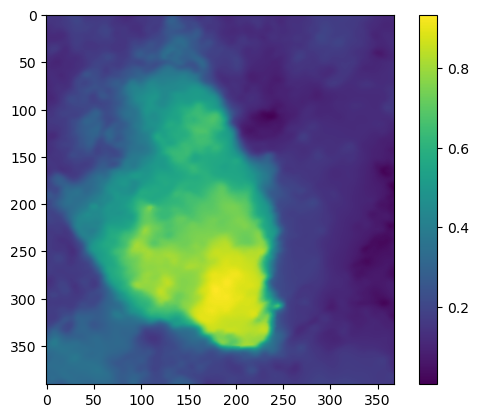

ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


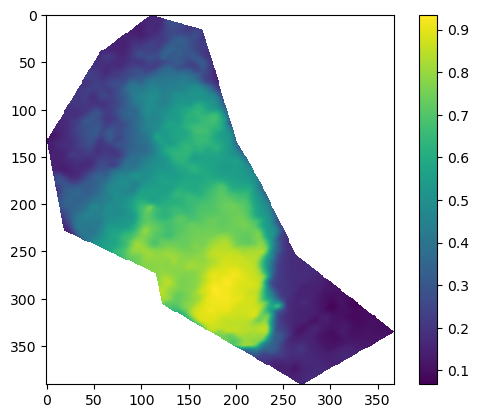

0.46087286023361573

In [31]:
chemin_raster = "/home/gaiani/Documents/STAGE/mont-vallon/raster_data/mont-vallon/displacements/mont-vallon_2014-09-13-SPOT6_2018-09-27-SPOT6/mont-vallon_2014-09-13-SPOT6_2018-09-27-SPOT6_v.tif"
chemin_shapefile = '/home/gaiani/Documents/STAGE/scripts_ronan/decoupage_GR2.shp'

interet = rt.pre_process(chemin_raster, geoim=True, geoExtent=chemin_shapefile, featureNum  = 0 )
interet.show()

interet_masque1 = interet.copy()
interet_masque1.maskFromVector(chemin_shapefile)
interet_masque1.show()
interet_masque1.mean()



ERROR 1: PROJ: internal_proj_create_from_database: /home/gaiani/miniconda3/envs/gis_env/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


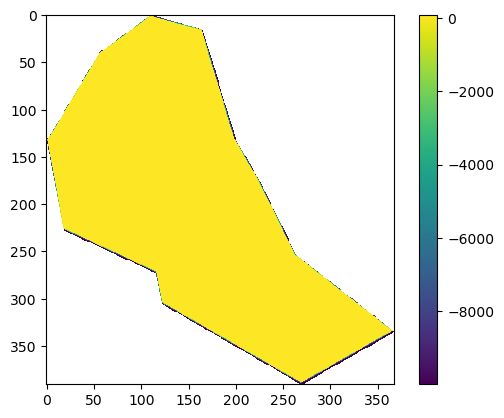

86.832344

In [30]:
chemin_raster_bis = "/home/gaiani/Documents/STAGE/scripts_ronan/pente-GR2.tif"

pente = rt.pre_process(chemin_raster_bis, geoim = True, geoExtent = chemin_shapefile, featureNum = 0)
pente_masque = pente.copy()
pente_masque.maskFromVector(chemin_shapefile)
pente_masque.show()
pente_masque.mean()
pente.array[200][200]